# Perspective Shift Identification

### Goal: 
Use ML to identify perspective shift in movement of distribution centers

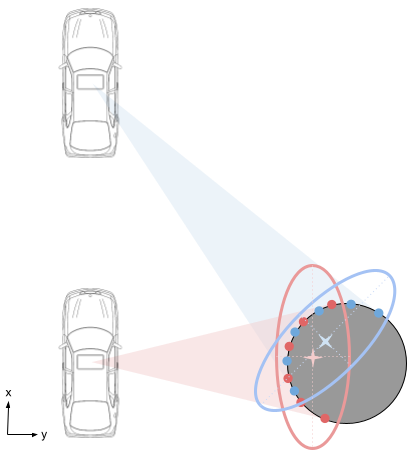

### Assumptions:
Gross rotation and translation have already been estimated by previous scan matching iterations

### Network structure:
Inputs: 
xyz of 25 points randomly sampled from each distribution

Output:
Correction factor translation between the two centers



### Training data generation

(starting with toy example)

1- generate grid of simple shapes in Inventor

2- Rotate randomly, translate randomly and simulate lidar scan of shapes at 2 points in time using MatLab script

3- Sample 25 points from each object and save to file. Also store information on rotation and translation to seperate file

4- import data here and augment again by duplicating and scaling examples arbitrarily

In [1]:
#setup - rememeber to switch to tensorflow 2.3 kernel...
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


2.3.0


Autosaving every 180 seconds


In [ ]:
#using tf.dataset API

pc_ds = tf.data.Dataset.list_files("E:/datasets/point_cloud/*")
for dat in pc_ds:
    print(dat)

In [18]:
#save scan to npy file so we don't have to deal with loading large text files
# np.save("C:/Users/Derm/Desktop/big/pshift/s1", d1)
# np.save("C:/Users/Derm/Desktop/big/pshift/s2", d2)
# np.save("C:/Users/Derm/Desktop/big/pshift/gt", gt)

#large training set
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_scan1_to4500.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_scan2_to4500.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_ground_truth_to4500.npy")
d1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_scan1_to400.npy")
d2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_scan2_to400.npy")
gt = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_ground_truth_to400.npy")

# n2keep = 500000

# d1 = d1[:n2keep*25,:]
# d2 = d2[:n2keep*25,:]
# gt = gt[:n2keep,:]


print(np.shape(d1))
print(np.shape(d2))
print(np.shape(gt))

(15821500, 3)
(15821500, 3)
(632860, 3)


In [19]:
#import training data
#toy data set
# d1 = np.loadtxt('training_data/scan1.txt')
# d2 = np.loadtxt('training_data/scan2.txt')
# gt = np.loadtxt('training_data/ground_truth.txt')

## slightly larger prism dataset
# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan1_10k.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan2_10k.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ground_truth_10k.txt")

#KITTI real world data
# d1 = np.loadtxt('training_data/ICET_KITTI_scan1.txt')
# d2 = np.loadtxt('training_data/ICET_KITTI_scan2.txt')
# gt = np.loadtxt('training_data/ICET_KITTI_ground_truth.txt')

# d1 = np.loadtxt('training_data/ICET_KITTI_scan1_25_shifted.txt')
# d2 = np.loadtxt('training_data/ICET_KITTI_scan2_25_shifted.txt')
# gt = np.loadtxt('training_data/ICET_KITTI_ground_truth_25_shifted.txt')

# d1 = np.loadtxt('training_data/ICET_Ford_scan1.txt')
# d2 = np.loadtxt('training_data/ICET_Ford_scan2.txt')
# gt = np.loadtxt('training_data/ICET_Ford_ground_truth.txt')

# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan1.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan2.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_ground_truth.txt")

# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan1_50.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan2_50.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_ground_truth_50.txt")

# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan1_50_shifted.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan2_50_shifted.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_ground_truth_50_shifted.txt")

# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_scan1.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_scan2.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_ground_truth.txt")

# d1 = np.loadtxt("training_data/ICET_KITTI_FULL_scan1_to10.txt")
# d2 = np.loadtxt("training_data/ICET_KITTI_FULL_scan2_to10.txt")
# gt = np.loadtxt("training_data/ICET_KITTI_FULL_ground_truth_to10.txt")

# #combine two datasets
# d1 = np.append(d1, d1_2, axis = 0)
# d2 = np.append(d2, d2_2, axis = 0)
# gt = np.append(gt, gt_2, axis = 0)

points_per_sample = 25 #50  #num pts per scan - defined in MatLab script
scan1 = tf.reshape(tf.convert_to_tensor(d1), [-1, points_per_sample, 3])
scan2 = tf.reshape(tf.convert_to_tensor(d2), [-1, points_per_sample, 3])
gt = tf.convert_to_tensor(gt)
# print(tf.shape(scan1))
# print(tf.shape(gt))

#split data into training and validation sets
tsplit = 0.95 #this fraction goes into training
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())
x_train = tf.concat((scan1[:ntrain], scan2[:ntrain]), axis = 1)
x_test = tf.concat((scan1[ntrain:], scan2[ntrain:]), axis = 1)
y_train = gt[:ntrain]
y_test = gt[ntrain:]

# x_train = tf.reshape(x_train, [-1, 50, 1, 1, 1])
print(tf.shape(x_train))
# x_train = tf.reshape(x_train, [-1, 50, 3])

# print(x_train[0,0,:])

tf.Tensor([601217     50      3], shape=(3,), dtype=int32)


In [21]:
#train network
from network import Net
# from network import permNet as Net
# from network import PointNet as Net
# from network import PCRnet as Net
np.random.seed(1337)

runLen = 15#60

def scheduler(epoch, learning_rate):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        learning_rate = 0.002
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.0005 #0.001
        return learning_rate
    if epoch >= part2:
        learning_rate = 0.0001 #0.00025
        return learning_rate

model = Net()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
              loss = tf.keras.losses.MeanAbsoluteError()) #was MeanSquaredError()

summary = model.summary()
print(summary)
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("KITTInetCP.kmod", monitor = 'val_loss', save_best_only = True) 

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

trace = model.fit(x = x_train, y = y_train, batch_size = 512, epochs=runLen, verbose=1, 
                  validation_split = 0.1, shuffle=True, callbacks = [scheduler, cp, tensorboard_callback])

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50, 3)]           0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 50, 3)             12        
_________________________________________________________________
dense_30 (Dense)             (None, 50, 64)            256       
_________________________________________________________________
batch_normalization_37 (Batc (None, 50, 64)            256       
_________________________________________________________________
dense_31 (Dense)             (None, 50, 128)           8320      
_________________________________________________________________
batch_normalization_38 (Batc (None, 50, 128)           512       
_________________________________________________________________
dense_32 (Dense)             (None, 50, 256)          

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: KITTInetCP.kmod\assets
1057/1057 [==============================] - 160s 151ms/step - loss: 0.0227 - val_loss: 0.0221
Epoch 7/15
1057/1057 [==============================] - 156s 148ms/step - loss: 0.0227 - val_loss: 0.0222
Epoch 8/15
1057/1057 [==============================] - ETA: 0s - loss: 0.0227WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x000002A941B13288> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand typ

<IPython.core.display.Javascript object>


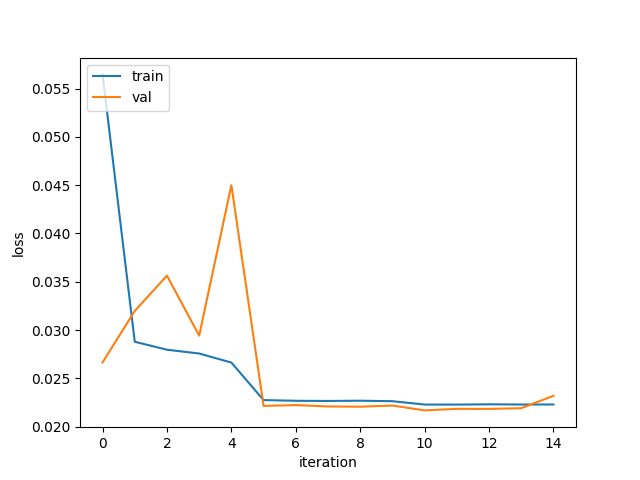

Text(0, 0.5, 'loss')

In [22]:
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('loss')

In [23]:
# estimates = model.predict(x_train[0:100:16])
# print(estimates)
# print(y_train[0:100:16])
estimates = model.predict(x_test[:10])
print("estimated translation x y z")
print(estimates)
print("actual translation x y z")
print(y_test)

err = y_test[:10] - estimates
# err = y_train[0:100:16] - estimates

print("\n Error \n",err)

print(tf.math.reduce_mean(tf.math.reduce_sum(err, axis = 1)))




Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
estimated translation x y z
[[-4.4017709e-03  1.1463894e-03 -3.1311229e-05]
 [-4.4017709e-03  1.1463894e-03 -3.1311229e-05]
 [-4.4017709e-03  1.1463894e-03 -3.1311229e-05]
 [ 4.2462814e-01 -9.2889333e-01 -1.1212025e-02]
 [ 8.9463019e-01 -1.7952744e+00 -5.9385642e-02]
 [ 5.9284925e-02 -1.2413640e-01 -8.9496205e-04]
 [-4.4017709e-03  1.1463894e-03 -3.1311229e-05]
 [

<IPython.core.display.Javascript object>


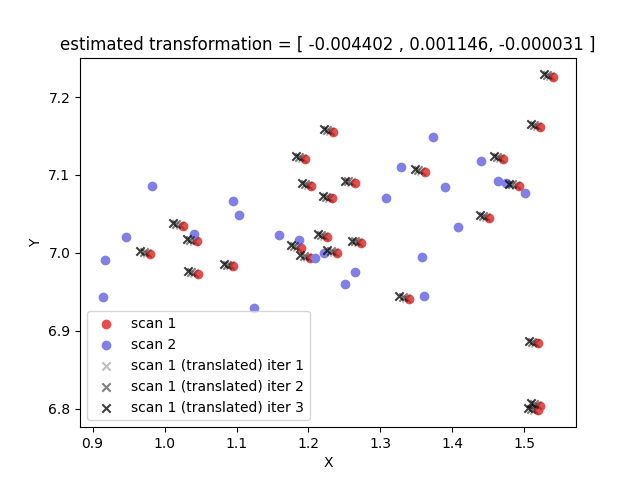

tf.Tensor([31643    50     3], shape=(3,), dtype=int32)
tf.Tensor([-5.9513416e-02  1.5469467e-03 -5.0867679e-05], shape=(3,), dtype=float32)


In [26]:
#visualize results of network on test data
#2d plots (x and y only)
fig1, ax1 = plt.subplots()
n = 50 #sample number (from x_test)
print(tf.shape(x_test))

c1 = np.array([x_test[n,:points_per_sample,0].numpy(), x_test[n,:points_per_sample,1].numpy(), x_test[n,:points_per_sample,2].numpy()])
c2 = np.array([x_test[n,points_per_sample:,0].numpy(), x_test[n,points_per_sample:,1].numpy(), x_test[n,points_per_sample:,2].numpy()])
ax1.scatter(c1[0,:], c1[1,:], color = [0.9, 0.3, 0.3], label = 'scan 1')
ax1.scatter(c2[0,:], c2[1,:], color = [0.5, 0.5, 0.9], label = 'scan 2')

# print(np.shape(x_test[n][None,:]))

inputs = x_test[n][None,:]
runlen = 3
for i in range(runlen):
    correction = model.predict(inputs)[0] #show what the network thinks
#     print(correction)
#     correction = 0.1*y_test[n] #show actual solution
    c1 = np.array([c1[0,:] + correction[0], c1[1,:] + correction[1], c1[2,:] + correction[2]])
    inputs = np.append(c1, c2, axis = 1).T[None,:,:]
    moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0., 0., 0., (i+1)/(runlen+1)],
                        label = 'scan 1 (translated) iter %i' %(i+1))

# moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0.9, 0.3, 0.3, (i+2)/(runlen+2)],
#                         label = 'scan 1 (translated)')

ax1.set_title("estimated transformation = [ %f , %f, %f ]" %(correction[0], correction[1], correction[2]))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend(loc = 'best')

print(y_test[n])

In [ ]:
#save network
# model.save("ffnet10k25.kmod")
model.save("Net.kmod")
# model.save("PIPEnet10.kmod")
# model.save("KITTInet.kmod")
# model.save("FULL_KITTInet4500.kmod")


#load network
# model = tf.keras.models.load_model("Net.kmod")3
# model = tf.keras.models.load_model("PIPEnet10.kmod")
# model = tf.keras.models.load_model("KITTInet.kmod")
# model = tf.keras.models.load_model("FORDnetCP.kmod")

In [ ]:
#test random shuffle layer to enforce training on unordered data
#GOAL: randomize order of each sample in batch SEPRATELY 
#      (i.e. don't have same order for all elements of batch)

test = tf.constant([[1., 3., 4.], [2., 3., 5.], [6., 6., 6.], [0., 0., 0.]])#[None, :, :]
test = tf.Variable([test, 2*test])
print(test)

test = tf.transpose(test, [1,0,2])
test = tf.random.shuffle(test)
test = tf.transpose(test, [1,0,2])
print(test)

### Top scores:

#### 1k dataset
8.23 MSE with no parallelization (vel = [5, 5, 5])

4.2 MSE (vel = [5, 5, 0.01])

3.9 MSE - 50 sample points from each scan

3.34- maxpool on first/ second half, conv after


#### 10k dataset

2.4 MSE 50 samples

1.05 MSE 25 samples -ffNet10k25.kmod

### KITTI drive 005, 100 frames

0.145 - Permnet

0.0895 -PCRnet

0.0520 KITTInet (5/20)

### KITTI drive 005, 150 frames, 50 sample points
0.759 pipeNET

### Ford Campus Drive 01 (200 frame sample)
0.073 - NET, 200 frames, with ground plane

### KITTI Full 00 400 frames, with ground plane
0.0752 net

### KITTI Full 00 400 frames, no ground plane
0.0756

### KITTI Full 00 4500 frames, with ground plane
0.0736 net


### Notes
From PointNet: Small rotations and gaussian noise can successfully augment models to increase training dataset

Need to figure out a way to achieve permutation invariance
Try transformer network i.e. "Attention is all you need"
https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html

Can potentially use reflectance as 4th dimension(?)

In [ ]:
8**3 